# LSTM Model for HAI Security Dataset Anomaly Detection

This notebook implements a Long Short-Term Memory (LSTM) neural network for anomaly detection on the HAI security dataset. LSTM networks are well-suited for time series anomaly detection due to their ability to capture temporal dependencies in the data.

In [24]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import time
import joblib
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Input, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available for training")
    # Set memory growth to avoid memory allocation errors
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU available, using CPU for training")

Num GPUs Available:  1
GPU is available for training


## 1. Load Preprocessed Data

First, let's load the preprocessed data created in the preprocessing notebook.

In [25]:
def load_processed_data(file_path):
    """
    Load processed data from NPZ file.
    
    Args:
        file_path: Path to the NPZ file
        
    Returns:
        DataFrame: Loaded data
    """
    # Load NPZ file
    npz_data = np.load(file_path, allow_pickle=True)
    
    # Convert to DataFrame
    df = pd.DataFrame(npz_data['data'], columns=npz_data['columns'])
    
    return df

In [26]:
# Load preprocessor
preprocessor_path = './models/hai_hai_20.07_standard_preprocessor.joblib'
preprocessor_dict = joblib.load(preprocessor_path)

# Extract important information
feature_columns = preprocessor_dict['feature_columns']
attack_columns = preprocessor_dict['attack_columns']
timestamp_col = preprocessor_dict['timestamp_col']

print(f"Number of features: {len(feature_columns)}")
print(f"Attack columns: {attack_columns}")
print(f"Timestamp column: {timestamp_col}")

Number of features: 59
Attack columns: ['attack', 'attack_P1', 'attack_P2', 'attack_P3']
Timestamp column: time


In [27]:
# Get list of processed data files
train_data_dir = './processed_data/hai-20.07/train'
test_data_dir = './processed_data/hai-20.07/test'

train_files = sorted(glob.glob(f'{train_data_dir}/*.npz'))
test_files = sorted(glob.glob(f'{test_data_dir}/*.npz'))

print(f"Training files: {[os.path.basename(f) for f in train_files]}")
print(f"Test files: {[os.path.basename(f) for f in test_files]}")

Training files: ['train1_chunk0.npz', 'train1_chunk1.npz', 'train1_chunk2.npz', 'train1_chunk3.npz', 'train2_chunk0.npz', 'train2_chunk1.npz', 'train2_chunk2.npz']
Test files: ['test1_chunk0.npz', 'test1_chunk1.npz', 'test1_chunk2.npz', 'test2_chunk0.npz', 'test2_chunk1.npz']


## 2. Prepare Data for LSTM

LSTM models require sequences of data as input. We'll create sequences of fixed length from our time series data.

In [28]:
def create_sequences(data, feature_cols, target_col=None, seq_length=100):
    """
    Create sequences for LSTM input.
    
    Args:
        data: DataFrame containing the data
        feature_cols: List of feature column names
        target_col: Target column name (None for unsupervised learning)
        seq_length: Length of each sequence
        
    Returns:
        tuple: (X, y) - Sequences and targets (if target_col is provided)
    """
    X = []
    y = [] if target_col is not None else None
    
    # Extract features
    features = data[feature_cols].values
    
    # Extract target if provided
    targets = data[target_col].values if target_col is not None else None
    
    # Create sequences
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        if target_col is not None:
            # Use the label of the last timestep in the sequence
            y.append(targets[i+seq_length])
    
    return np.array(X), np.array(y) if target_col is not None else None

In [29]:
def load_and_prepare_data(file_paths, feature_cols, target_col=None, seq_length=100, max_files=None):
    """
    Load and prepare data from multiple files.
    
    Args:
        file_paths: List of file paths
        feature_cols: List of feature column names
        target_col: Target column name (None for unsupervised learning)
        seq_length: Length of each sequence
        max_files: Maximum number of files to load (None for all files)
        
    Returns:
        tuple: (X, y) - Combined sequences and targets
    """
    all_X = []
    all_y = [] if target_col is not None else None
    
    # Limit the number of files if specified
    if max_files is not None:
        file_paths = file_paths[:max_files]
    
    for file_path in file_paths:
        print(f"Processing {os.path.basename(file_path)}...")
        
        # Load data
        df = load_processed_data(file_path)
        
        # Create sequences
        X, y = create_sequences(df, feature_cols, target_col, seq_length)
        
        all_X.append(X)
        if target_col is not None:
            all_y.append(y)
    
    # Combine data from all files
    combined_X = np.vstack(all_X) if all_X else np.array([])
    combined_y = np.concatenate(all_y) if all_y else None
    
    return combined_X, combined_y

In [30]:
# Set parameters
seq_length = 100  # Sequence length (number of time steps)
target_col = 'attack' if attack_columns else None  # Target column

# Load and prepare training data
print("Loading and preparing training data...")
X_train, _ = load_and_prepare_data(train_files, feature_columns, target_col=None, seq_length=seq_length, max_files=2)

# Load and prepare test data
print("\nLoading and preparing test data...")
X_test, y_test = load_and_prepare_data(test_files, feature_columns, target_col=target_col, seq_length=seq_length, max_files=2)

print(f"\nTraining data shape: {X_train.shape}")
if y_test is not None:
    print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")
else:
    print(f"Test data shape: {X_test.shape}")

Loading and preparing training data...
Processing train1_chunk0.npz...
Processing train1_chunk1.npz...

Loading and preparing test data...
Processing test1_chunk0.npz...
Processing test1_chunk1.npz...

Training data shape: (199800, 100, 59)
Test data shape: (199800, 100, 59), Test labels shape: (199800,)


## 3. Build LSTM Autoencoder Model

We'll use an LSTM autoencoder for anomaly detection. The autoencoder will learn to reconstruct normal behavior, and anomalies will have higher reconstruction errors.

In [31]:
def build_lstm_autoencoder(input_shape, encoding_dim=32):
    """
    Build an LSTM autoencoder model.
    
    Args:
        input_shape: Shape of input data (seq_length, num_features)
        encoding_dim: Dimension of the encoded representation
        
    Returns:
        tuple: (model, encoder, decoder) - Full model, encoder part, and decoder part
    """
    # Encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm1 = LSTM(128, return_sequences=True)(encoder_inputs)
    encoder_bn1 = BatchNormalization()(encoder_lstm1)
    encoder_lstm2 = LSTM(64, return_sequences=False)(encoder_bn1)
    encoder_bn2 = BatchNormalization()(encoder_lstm2)
    encoder_output = Dense(encoding_dim)(encoder_bn2)
    
    # Decoder
    decoder_inputs = Input(shape=(encoding_dim,))
    decoder_dense1 = Dense(64)(decoder_inputs)
    decoder_bn1 = BatchNormalization()(decoder_dense1)
    decoder_repeat = RepeatVector(input_shape[0])(decoder_bn1)
    decoder_lstm1 = LSTM(64, return_sequences=True)(decoder_repeat)
    decoder_bn2 = BatchNormalization()(decoder_lstm1)
    decoder_lstm2 = LSTM(128, return_sequences=True)(decoder_bn2)
    decoder_bn3 = BatchNormalization()(decoder_lstm2)
    decoder_output = TimeDistributed(Dense(input_shape[1]))(decoder_bn3)
    
    # Create models
    encoder = Model(encoder_inputs, encoder_output, name='encoder')
    decoder = Model(decoder_inputs, decoder_output, name='decoder')
    
    # Autoencoder (end-to-end model)
    autoencoder_output = decoder(encoder(encoder_inputs))
    autoencoder = Model(encoder_inputs, autoencoder_output, name='autoencoder')
    
    return autoencoder, encoder, decoder

In [32]:
# Set model parameters
encoding_dim = 32  # Dimension of the encoded representation
input_shape = (X_train.shape[1], X_train.shape[2])  # (seq_length, num_features)

# Build model
autoencoder, encoder, decoder = build_lstm_autoencoder(input_shape, encoding_dim)

# Compile model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Print model summary
autoencoder.summary()

2025-03-04 10:34:46.477365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78761 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:42:00.0, compute capability: 8.0
2025-03-04 10:34:46.590658: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 59)]         0         
                                                                 
 encoder (Functional)        (None, 32)                148512    
                                                                 
 decoder (Functional)        (None, 100, 59)           142587    
                                                                 
Total params: 291099 (1.11 MB)
Trainable params: 290203 (1.11 MB)
Non-trainable params: 896 (3.50 KB)
_________________________________________________________________


## 4. Train LSTM Autoencoder Model

Now we'll train the autoencoder on normal data (without attacks) to learn the normal behavior patterns.

In [33]:
# Set training parameters
batch_size = 64
epochs = 50
validation_split = 0.1

# Create model checkpoint callback
os.makedirs('./models', exist_ok=True)
checkpoint_path = './models/lstm_autoencoder_hai_20_07.h5'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10, 
                              verbose=1, 
                              mode='min', 
                              restore_best_weights=True)

# Create TensorBoard callback
log_dir = './logs/lstm_autoencoder_' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, 
                         histogram_freq=1, 
                         write_graph=True, 
                         write_images=True)

# Combine callbacks
callbacks = [checkpoint, early_stopping, tensorboard]

In [36]:
# 將數據轉換為 float32 類型
X_train = X_train.astype('float32')

In [37]:
# Train model
start_time = time.time()

history = autoencoder.fit(
    X_train, X_train,  # Input and output are the same for autoencoder
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Epoch 1/50


2025-03-04 10:40:25.071178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-03-04 10:40:25.736590: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xad70c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-04 10:40:25.736612: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-03-04 10:40:25.740160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-04 10:40:25.818924: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2810/2810 [==============================] - ETA: 0s - loss: 0.6001
Epoch 1: val_loss improved from inf to 0.22906, saving model to ./models/lstm_autoencoder_hai_20_07.h5
2810/2810 [==============================] - 116s 39ms/step - loss: 0.6001 - val_loss: 0.2291
Epoch 2/50
2809/2810 [============================>.] - ETA: 0s - loss: 0.4429
Epoch 2: val_loss improved from 0.22906 to 0.22549, saving model to ./models/lstm_autoencoder_hai_20_07.h5
2810/2810 [==============================] - 105s 37ms/step - loss: 0.4429 - val_loss: 0.2255
Epoch 3/50
2809/2810 [============================>.] - ETA: 0s - loss: 0.4086
Epoch 3: val_loss improved from 0.22549 to 0.20669, saving model to ./models/lstm_autoencoder_hai_20_07.h5
2810/2810 [==============================] - 105s 37ms/step - loss: 0.4085 - val_loss: 0.2067
Epoch 4/50
2810/2810 [==============================] - ETA: 0s - loss: 0.4194
Epoch 4: val_loss did not improve from 0.20669
2810/2810 [==============================] - 104s

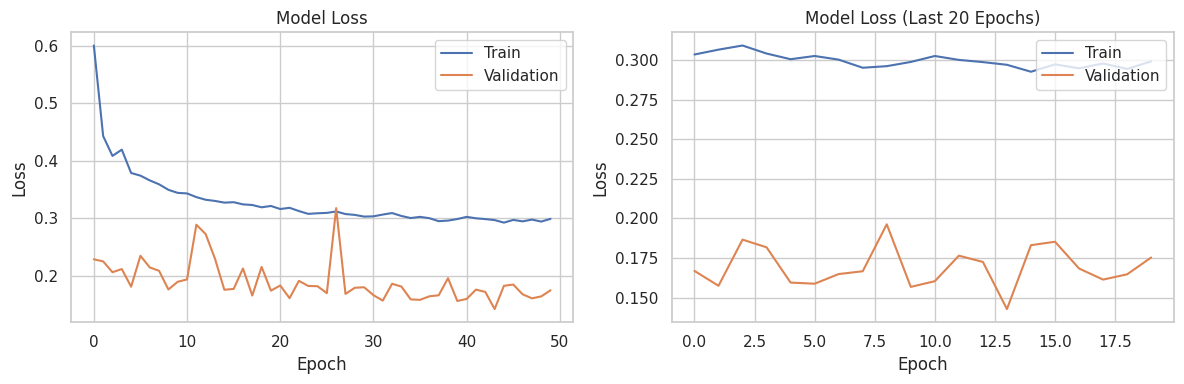

In [38]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot zoomed-in view of the last epochs
plt.subplot(1, 2, 2)
last_epochs = min(20, len(history.history['loss']))  # Last 20 epochs or all if less
plt.plot(history.history['loss'][-last_epochs:])
plt.plot(history.history['val_loss'][-last_epochs:])
plt.title(f'Model Loss (Last {last_epochs} Epochs)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 5. Evaluate Model and Detect Anomalies

Now we'll use the trained autoencoder to detect anomalies in the test data.

In [41]:
print("X_test shape:", X_test.shape)


X_test shape: (199800, 100, 59)


In [43]:
# Load the best model
# Load the best model
best_model = load_model(checkpoint_path)
best_model.summary()
print("Expected input shape:", best_model.input_shape)

# Check data type
print("X_test shape:", X_test.shape)
print("X_test dtype:", X_test.dtype)

# Convert object array to float32 array
print("Converting object array to float32...")
X_test_float = np.zeros(X_test.shape, dtype='float32')

# Examine a sample to understand what we're dealing with
sample = X_test[0, 0, 0]
print("Sample element type:", type(sample))
print("Sample element value:", sample)

# Convert each element explicitly
try:
    # For simple number objects
    X_test_float = np.array(X_test, dtype='float32')
except (ValueError, TypeError) as e:
    print(f"Simple conversion failed: {e}")
    
    # Try element-wise conversion
    try:
        for i in range(X_test.shape[0]):
            if i % 10000 == 0:
                print(f"Processing sample {i}/{X_test.shape[0]}")
            for j in range(X_test.shape[1]):
                for k in range(X_test.shape[2]):
                    try:
                        value = float(X_test[i, j, k])
                        X_test_float[i, j, k] = value
                    except (ValueError, TypeError):
                        # Set to 0 if conversion fails
                        X_test_float[i, j, k] = 0.0
    except Exception as e:
        print(f"Element-wise conversion failed: {e}")

# Verify conversion
print("Converted X_test dtype:", X_test_float.dtype)
print("Converted X_test contains NaN:", np.isnan(X_test_float).any())
print("Converted X_test contains Inf:", np.isinf(X_test_float).any())

# Clean the data - replace NaN and Inf values with 0
X_test_cleaned = np.nan_to_num(X_test_float, nan=0.0, posinf=0.0, neginf=0.0)

# Predict in batches to avoid memory issues
batch_size = 1000  # Adjust based on your available memory
predictions = []

for i in range(0, len(X_test_cleaned), batch_size):
    batch = X_test_cleaned[i:i+batch_size]
    batch_pred = best_model.predict(batch, verbose=0)
    predictions.append(batch_pred)

X_test_pred = np.vstack(predictions)

# Calculate reconstruction error
mse = np.mean(np.square(X_test_cleaned - X_test_pred), axis=(1, 2))

# Output statistics
print(f"Reconstruction error statistics:")
print(f"Min: {np.min(mse):.6f}")
print(f"Max: {np.max(mse):.6f}")
print(f"Mean: {np.mean(mse):.6f}")
print(f"Std: {np.std(mse):.6f}")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 59)]         0         
                                                                 
 encoder (Functional)        (None, 32)                148512    
                                                                 
 decoder (Functional)        (None, 100, 59)           142587    
                                                                 
Total params: 291099 (1.11 MB)
Trainable params: 290203 (1.11 MB)
Non-trainable params: 896 (3.50 KB)
_________________________________________________________________
Expected input shape: (None, 100, 59)
X_test shape: (199800, 100, 59)
X_test dtype: object
Converting object array to float32...
Sample element type: <class 'float'>
Sample element value: -1.036189903041326
Converted X_test dtype: float32
Converted X_test contains NaN: False
Convert

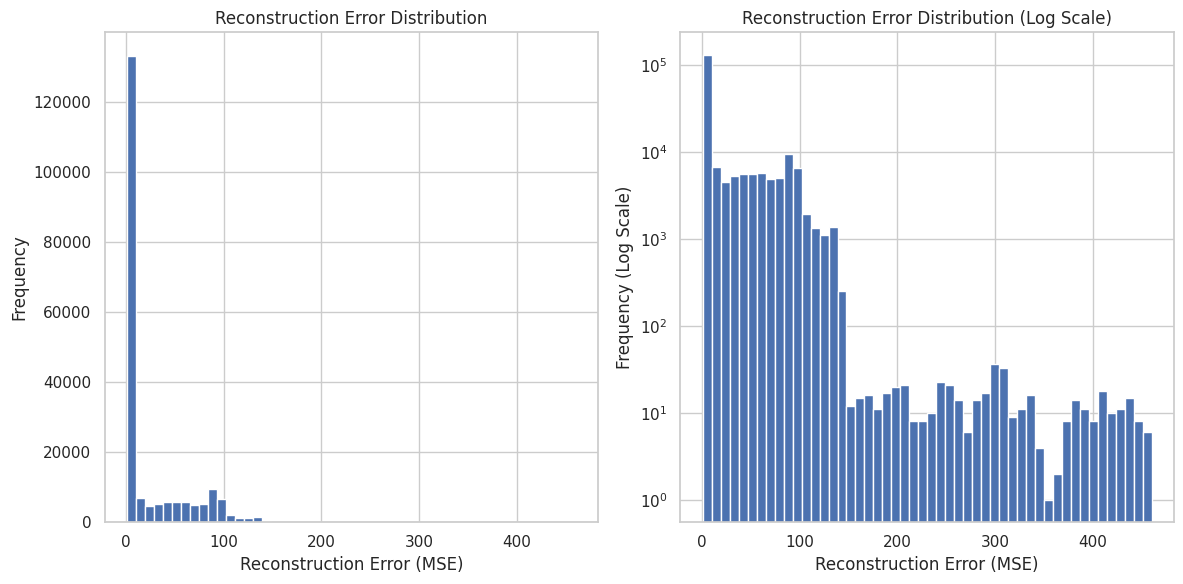

In [44]:
# Plot reconstruction error distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(mse, bins=50)
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(mse, bins=50, log=True)
plt.title('Reconstruction Error Distribution (Log Scale)')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency (Log Scale)')

plt.tight_layout()
plt.show()

### 5.1 Determine Anomaly Threshold

We need to determine a threshold for the reconstruction error to classify data points as normal or anomalous.

In [45]:
def find_optimal_threshold(mse, y_true):
    """
    Find the optimal threshold for anomaly detection using ROC curve.
    
    Args:
        mse: Reconstruction error values
        y_true: True labels (0 for normal, 1 for anomaly)
        
    Returns:
        float: Optimal threshold value
    """
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, mse)
    
    # Calculate the geometric mean of sensitivity and specificity
    gmeans = np.sqrt(tpr * (1 - fpr))
    
    # Find the optimal threshold
    ix = np.argmax(gmeans)
    optimal_threshold = thresholds[ix]
    
    print(f"Optimal threshold: {optimal_threshold:.6f}")
    print(f"At this threshold - TPR: {tpr[ix]:.4f}, FPR: {fpr[ix]:.4f}, G-mean: {gmeans[ix]:.4f}")
    
    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Optimal (Threshold = {optimal_threshold:.6f})')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return optimal_threshold

Optimal threshold: 4.475538
At this threshold - TPR: 0.8379, FPR: 0.3670, G-mean: 0.7283


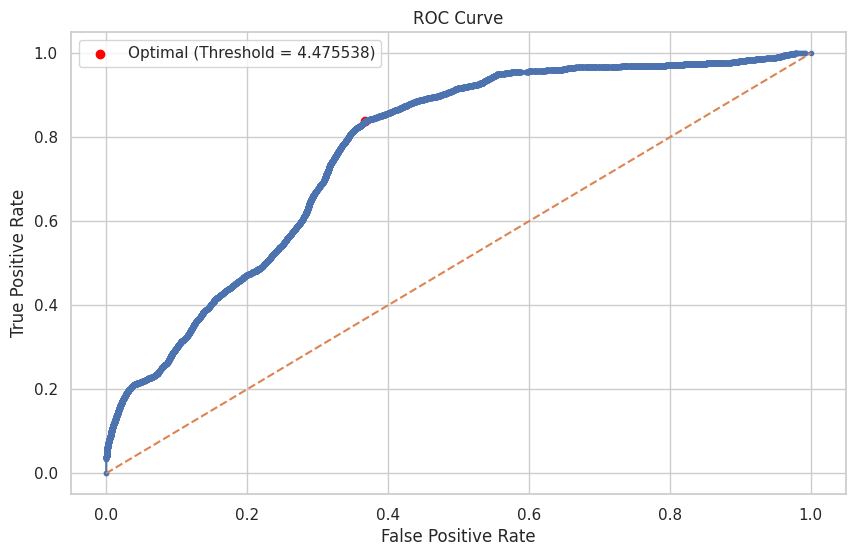

In [46]:
# Find optimal threshold if labels are available
if y_test is not None:
    threshold = find_optimal_threshold(mse, y_test)
else:
    # If no labels, use a statistical approach
    threshold = np.mean(mse) + 3 * np.std(mse)  # Mean + 3 standard deviations
    print(f"Using statistical threshold: {threshold:.6f}")

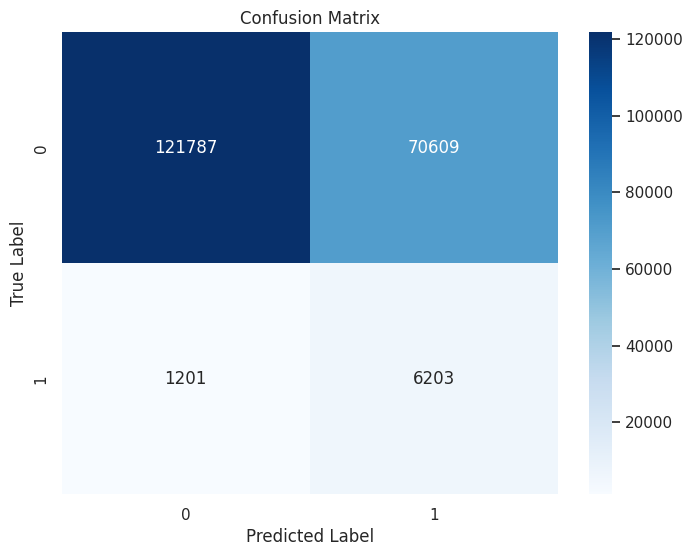

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77    192396
           1       0.08      0.84      0.15      7404

    accuracy                           0.64    199800
   macro avg       0.54      0.74      0.46    199800
weighted avg       0.96      0.64      0.75    199800

ROC AUC: 0.7676


In [47]:
# Classify as anomaly if reconstruction error > threshold
y_pred = (mse > threshold).astype(int)

# Evaluate if labels are available
if y_test is not None:
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate ROC AUC
    roc_auc = auc(*roc_curve(y_test, mse)[:2])
    print(f"ROC AUC: {roc_auc:.4f}")

### 5.2 Visualize Anomalies

Let's visualize some examples of normal and anomalous sequences.

In [48]:
def plot_reconstruction_examples(X, X_pred, mse, threshold, y_true=None, num_examples=3):
    """
    Plot examples of normal and anomalous sequences with their reconstructions.
    
    Args:
        X: Original sequences
        X_pred: Reconstructed sequences
        mse: Reconstruction errors
        threshold: Anomaly threshold
        y_true: True labels (optional)
        num_examples: Number of examples to plot for each category
    """
    # Predicted labels
    y_pred = (mse > threshold).astype(int)
    
    # Find indices of true positives, false positives, true negatives, and false negatives
    if y_true is not None:
        tp_indices = np.where((y_true == 1) & (y_pred == 1))[0]
        fp_indices = np.where((y_true == 0) & (y_pred == 1))[0]
        tn_indices = np.where((y_true == 0) & (y_pred == 0))[0]
        fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]
        
        categories = [
            ('True Positive (Correctly Detected Anomaly)', tp_indices),
            ('False Positive (False Alarm)', fp_indices),
            ('True Negative (Correctly Identified Normal)', tn_indices),
            ('False Negative (Missed Anomaly)', fn_indices)
        ]
    else:
        # If no true labels, just show predicted anomalies and normal
        anomaly_indices = np.where(y_pred == 1)[0]
        normal_indices = np.where(y_pred == 0)[0]
        
        categories = [
            ('Predicted Anomaly', anomaly_indices),
            ('Predicted Normal', normal_indices)
        ]
    
    # Plot examples for each category
    for category_name, indices in categories:
        if len(indices) == 0:
            print(f"No examples found for category: {category_name}")
            continue
        
        # Select random examples
        selected_indices = np.random.choice(indices, size=min(num_examples, len(indices)), replace=False)
        
        for i, idx in enumerate(selected_indices):
            # Select a random feature to visualize
            feature_idx = np.random.randint(0, X.shape[2])
            
            plt.figure(figsize=(12, 6))
            plt.subplot(2, 1, 1)
            plt.plot(X[idx, :, feature_idx], label='Original')
            plt.plot(X_pred[idx, :, feature_idx], label='Reconstruction')
            plt.title(f"{category_name} - Example {i+1} (Feature {feature_idx}) - MSE: {mse[idx]:.6f}")
            plt.legend()
            plt.grid(True)
            
            plt.subplot(2, 1, 2)
            plt.plot(np.abs(X[idx, :, feature_idx] - X_pred[idx, :, feature_idx]), color='red')
            plt.title('Absolute Reconstruction Error')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()

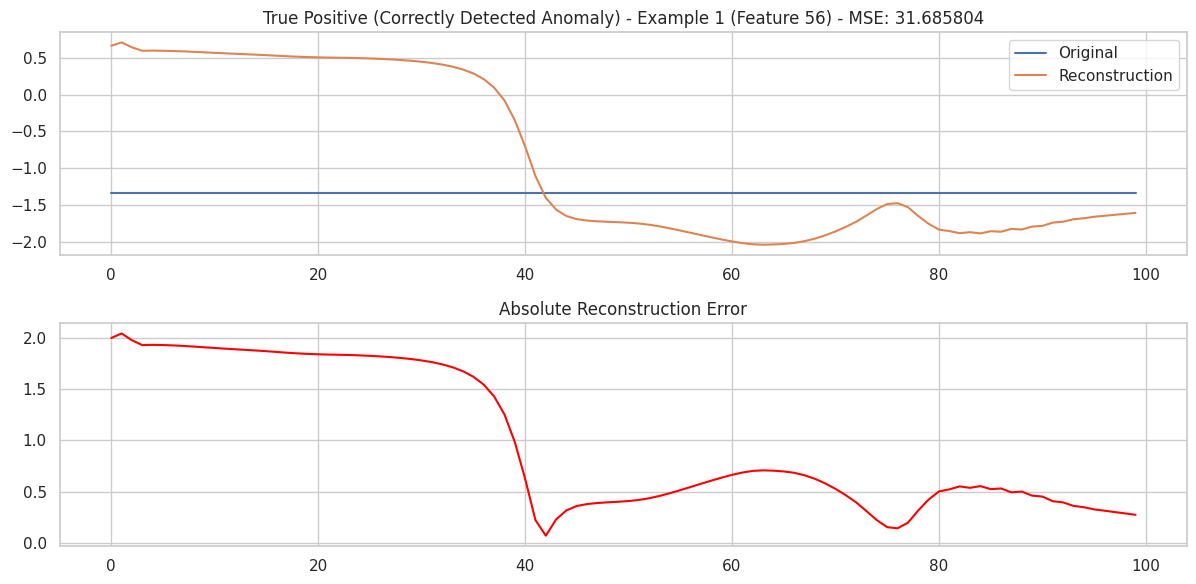

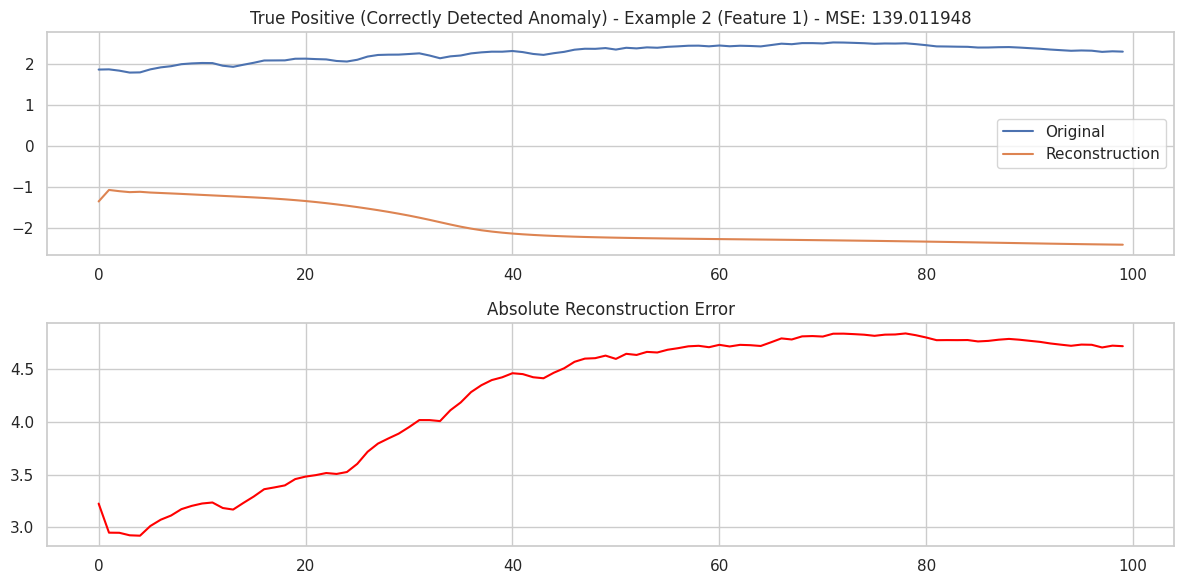

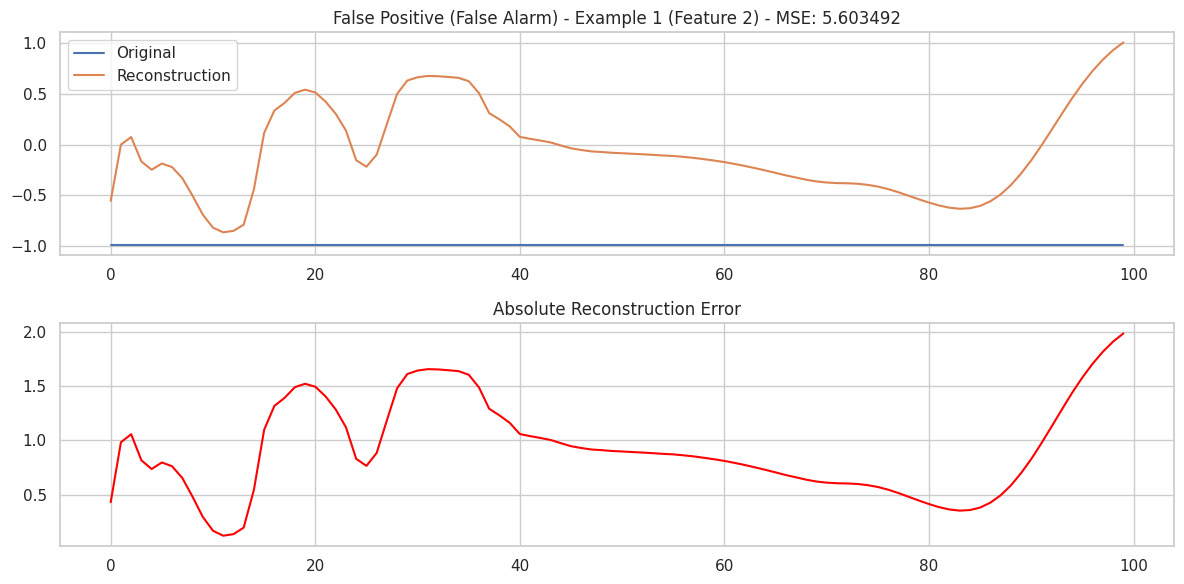

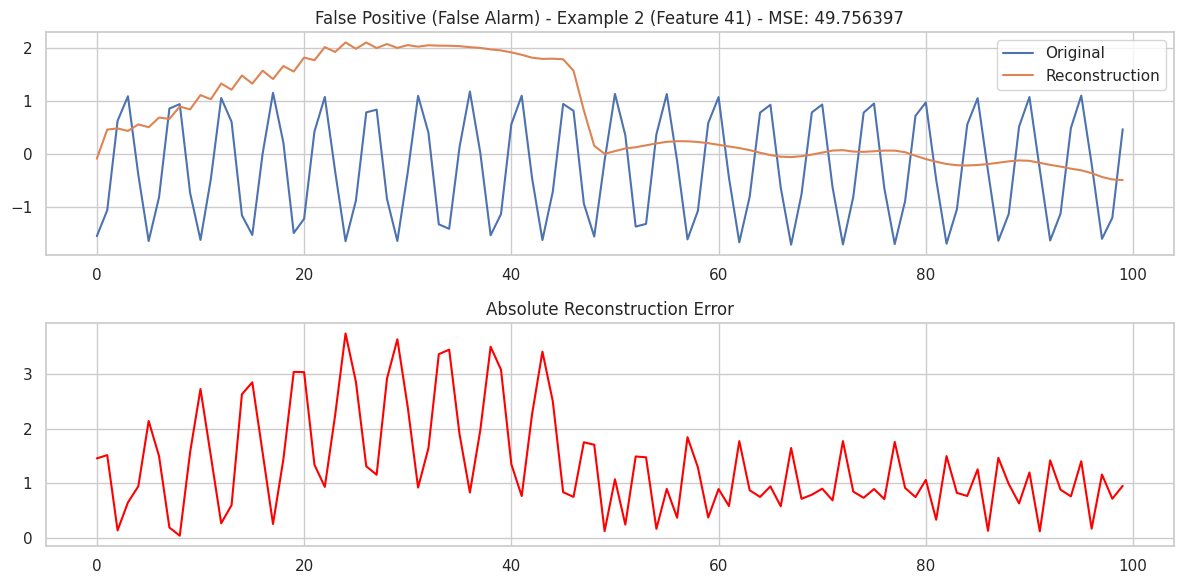

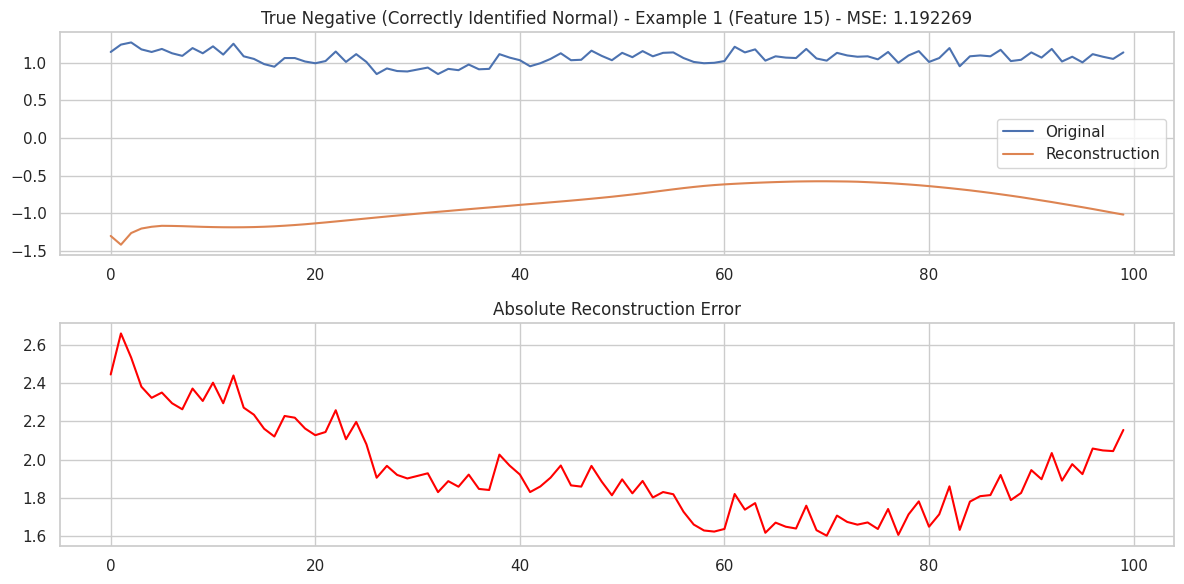

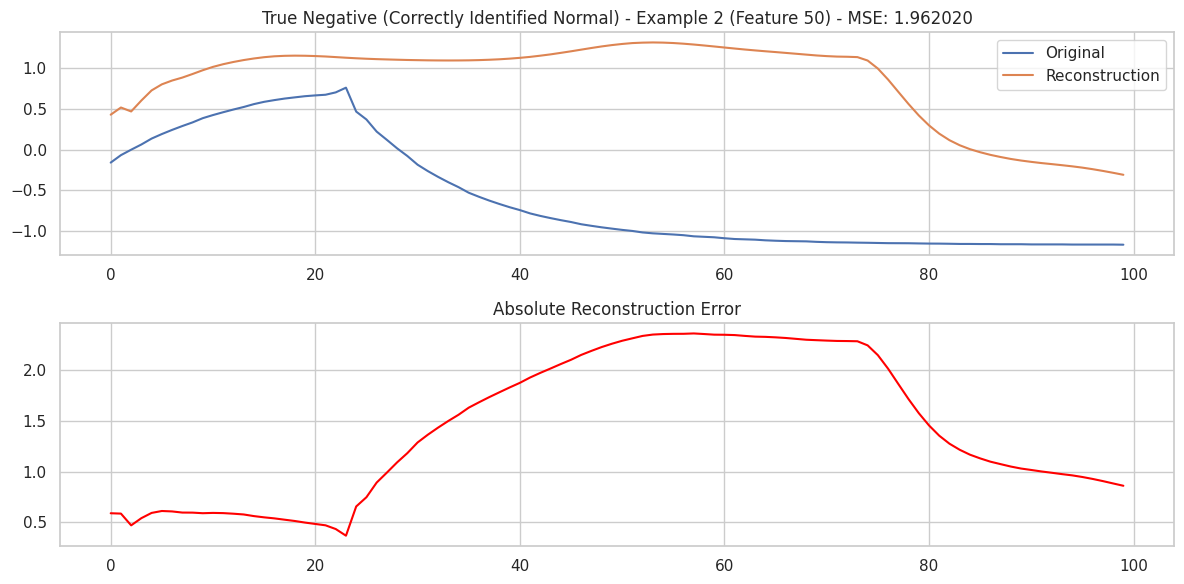

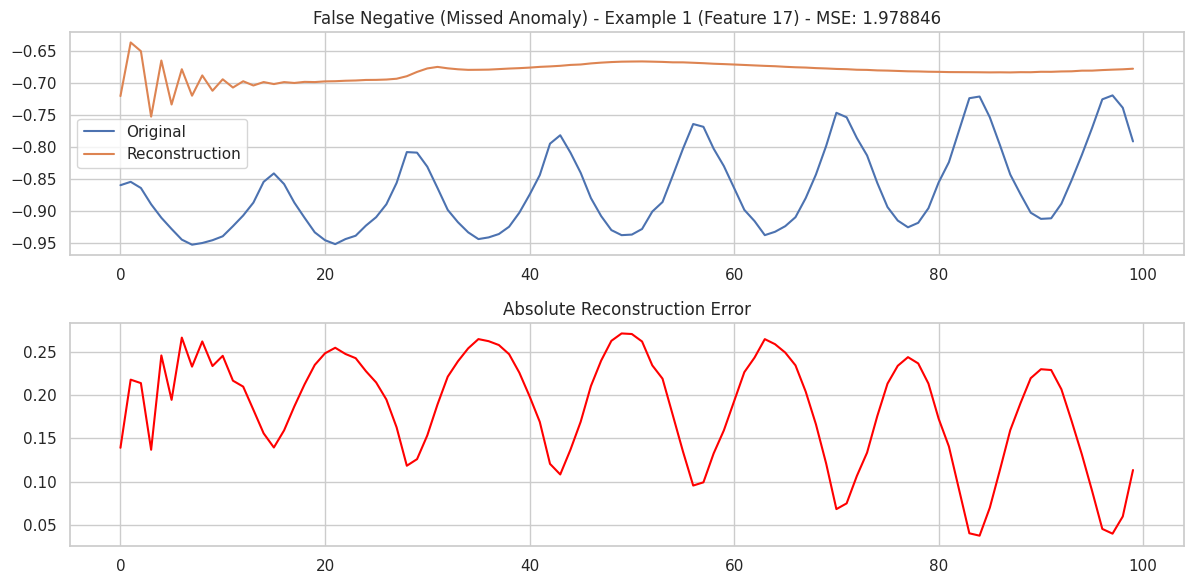

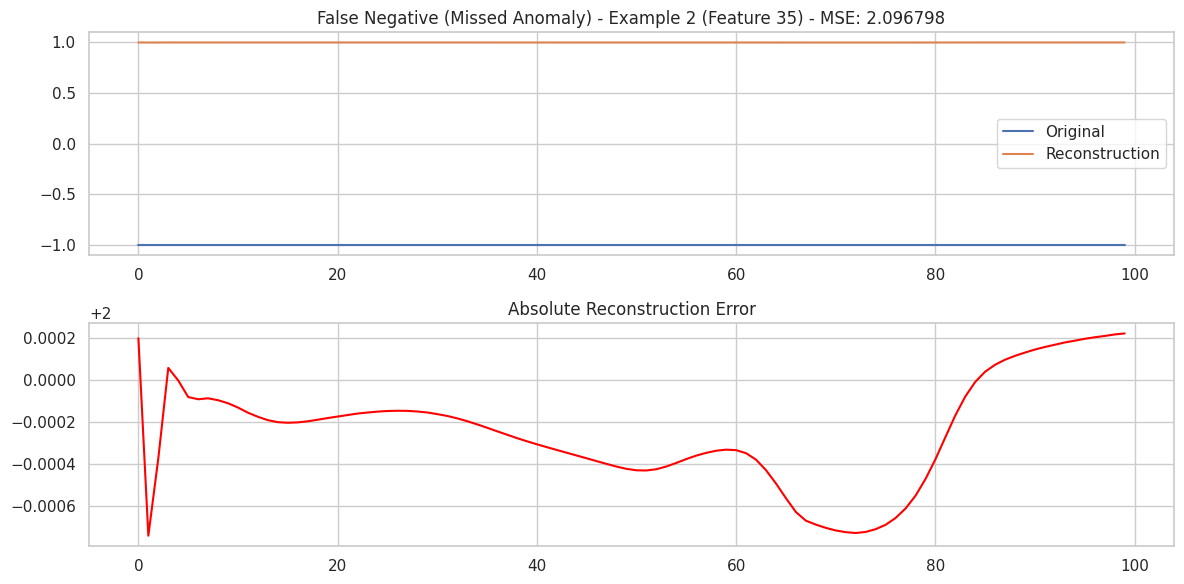

In [49]:
# Plot reconstruction examples
plot_reconstruction_examples(X_test, X_test_pred, mse, threshold, y_test, num_examples=2)

### 5.3 Analyze Anomaly Patterns

Let's analyze the patterns of detected anomalies to understand their characteristics.

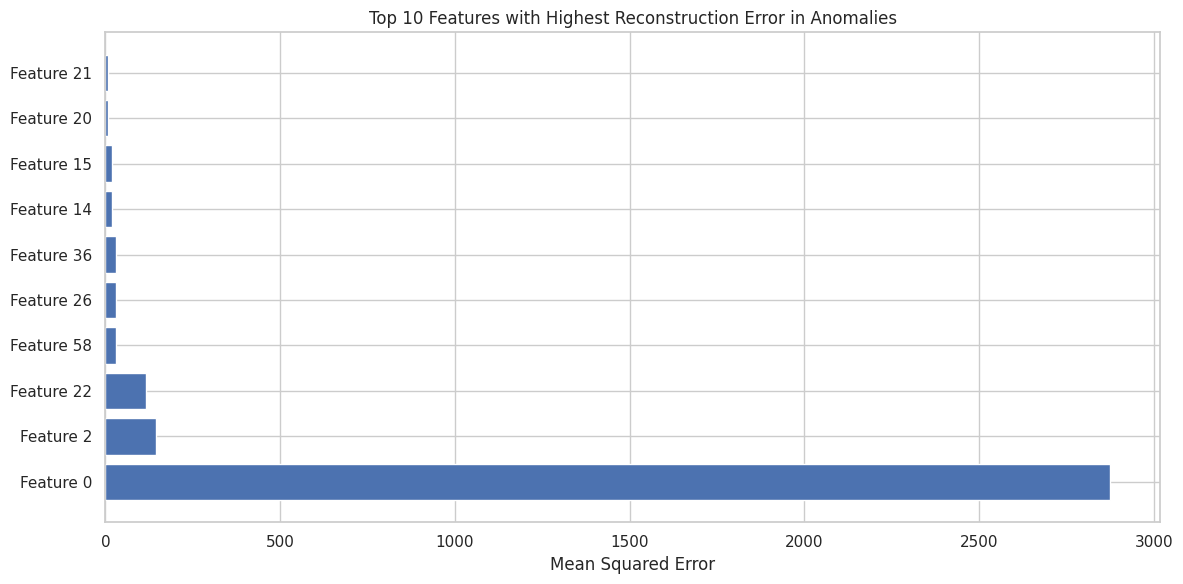

Top 10 features with highest reconstruction error in anomalies:
1. Feature 0: 2873.021262
2. Feature 2: 143.682960
3. Feature 22: 117.347458
4. Feature 58: 31.043324
5. Feature 26: 30.875848
6. Feature 36: 28.792601
7. Feature 14: 19.540388
8. Feature 15: 18.011626
9. Feature 20: 7.153823
10. Feature 21: 6.957842


In [50]:
# Calculate feature-wise reconstruction error
feature_mse = np.mean(np.square(X_test - X_test_pred), axis=1)  # Average over time steps

# Get indices of anomalies
anomaly_indices = np.where(y_pred == 1)[0]

if len(anomaly_indices) > 0:
    # Calculate average feature-wise error for anomalies
    anomaly_feature_mse = feature_mse[anomaly_indices].mean(axis=0)
    
    # Get top 10 features with highest reconstruction error
    top_features_idx = np.argsort(anomaly_feature_mse)[-10:]
    top_features_error = anomaly_feature_mse[top_features_idx]
    
    # Plot top features
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(top_features_idx)), top_features_error[::-1])
    plt.yticks(range(len(top_features_idx)), [f"Feature {idx}" for idx in top_features_idx[::-1]])
    plt.title('Top 10 Features with Highest Reconstruction Error in Anomalies')
    plt.xlabel('Mean Squared Error')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 features with highest reconstruction error in anomalies:")
    for i, idx in enumerate(top_features_idx[::-1]):
        print(f"{i+1}. Feature {idx}: {anomaly_feature_mse[idx]:.6f}")
else:
    print("No anomalies detected.")

## 6. Save Model and Results

Finally, let's save the model and results for future use.

In [51]:
# Save model components
os.makedirs('./models', exist_ok=True)
encoder.save('./models/lstm_encoder_hai_20_07.h5')
decoder.save('./models/lstm_decoder_hai_20_07.h5')

# Save threshold and other metadata
model_metadata = {
    'threshold': threshold,
    'encoding_dim': encoding_dim,
    'seq_length': seq_length,
    'feature_columns': feature_columns,
    'training_history': {
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }
}

joblib.dump(model_metadata, './models/lstm_model_metadata_hai_20_07.joblib')
print("Model and metadata saved successfully.")

Model and metadata saved successfully.


## 7. Conclusion

In this notebook, we've implemented an LSTM autoencoder for anomaly detection on the HAI security dataset. The model learns to reconstruct normal behavior patterns and identifies anomalies based on reconstruction error. Key steps included:

1. Loading and preparing preprocessed data
2. Building an LSTM autoencoder model
3. Training the model on normal data
4. Detecting anomalies using reconstruction error
5. Evaluating the model's performance
6. Analyzing anomaly patterns

The LSTM autoencoder provides an effective approach for detecting anomalies in industrial control system data, which can help identify potential security threats or system malfunctions.